In [1]:
%matplotlib inline
import gdax
from api_key import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import time
from pprint import pprint
from gdax_helpers import *

In [2]:
auth_client = gdax.AuthenticatedClient(KEY,
                                       B64SECRET,
                                       PASSPHRASE)
res = get_portfolio_history(auth_client)

ETH-USD Starting 2017-12-20 00:14:53.193794
found ETH-USD data
from 2017-07-05 18:00:00
to   2018-01-07 13:00:00
Filling from
2018-01-07 13:00:00
to
2018-01-07 22:00:00
storing ETH-USD in prices.h5
BTC-USD Starting 2017-12-19 22:37:14.513654
found BTC-USD data
from 2017-01-01 17:00:00
to   2018-01-07 13:00:00
Filling from
2018-01-07 13:00:00
to
2018-01-07 22:00:00
storing BTC-USD in prices.h5


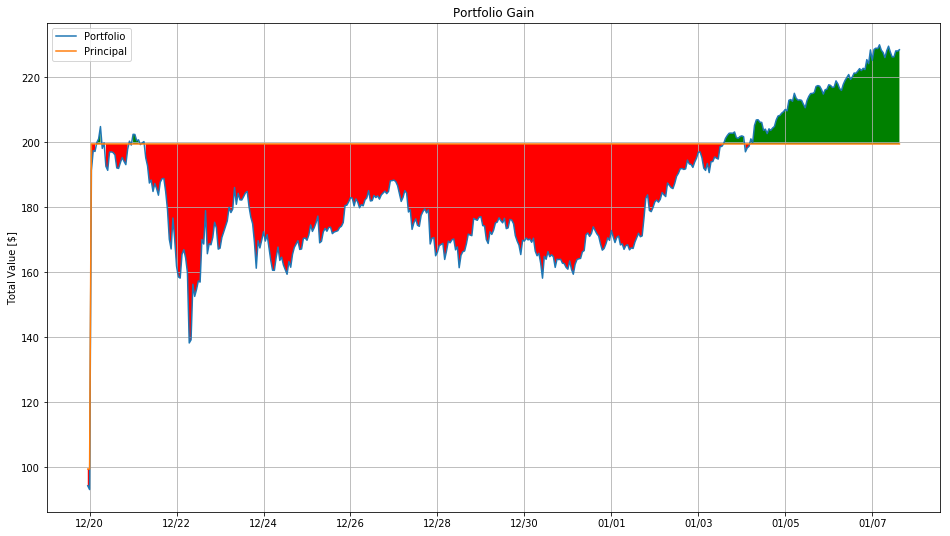

In [3]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.grid(True)
ax.plot(res['total']['close'])
ax.plot(res['principal'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.legend(['Portfolio', 'Principal'])
ax.set_title('Portfolio Gain')
# ax.set_ylim(0, 300)
ax.set_ylabel('Total Value [$]')

y1 = res['principal'].values
y2 = res['total']['close'].values
ax.fill_between(
    x=res['principal'].index,
    y1=y1,
    y2=y2,
    where=y2 <= y1,
    facecolor='red'
)

ax.fill_between(
    x=res['principal'].index,
    y1=y1,
    y2=y2,
    where=y2 >= y1,
    facecolor='green'
)

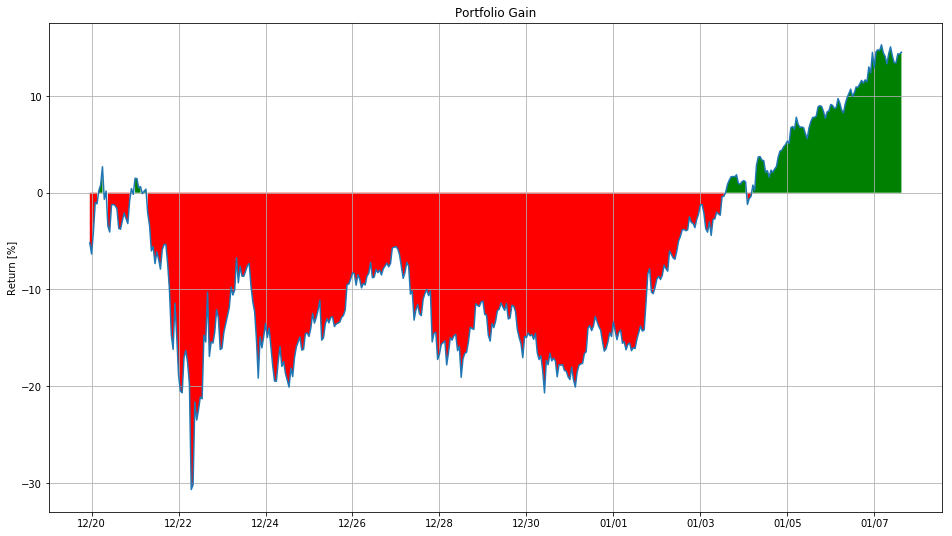

In [4]:
data = res['total']['close'].divide(res['principal'], axis=0) - 1
data *= 100
fig, ax = plt.subplots(figsize=(16, 9))
ax.grid(True)
ax.plot(data)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.set_title('Portfolio Gain')
# ax.set_ylim(-50, 50)
ax.set_ylabel('Return [%]')

y1 = data.values
y2 = np.full((len(data.values)), 0)
ax.fill_between(
    x=data.index,
    y1=y1,
    y2=y2,
    where=y2 <= y1,
    facecolor='green'
)

ax.fill_between(
    x=data.index,
    y1=y1,
    y2=y2,
    where=y2 >= y1,
    facecolor='red'
)

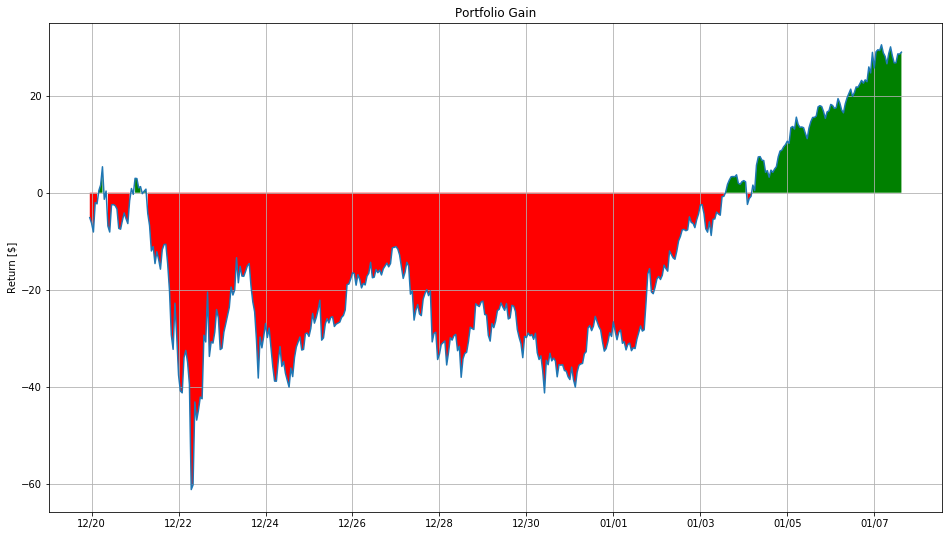

In [5]:
data = res['total']['close'].subtract(res['principal'], axis=0)
fig, ax = plt.subplots(figsize=(16, 9))
ax.grid(True)
ax.plot(data)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.set_title('Portfolio Gain')
# ax.set_ylim(-100, 100)
ax.set_ylabel('Return [$]')

y1 = data.values
y2 = np.full((len(data.values)), 0)
ax.fill_between(
    x=data.index,
    y1=y1,
    y2=y2,
    where=y2 <= y1,
    facecolor='green'
)

ax.fill_between(
    x=data.index,
    y1=y1,
    y2=y2,
    where=y2 >= y1,
    facecolor='red'
)